## Introduction

- The goal is to build and train a neural network from scratch using torch.
- We'll be using Kaggle's [Titanic](https://www.kaggle.com/competitions/titanic/) competition dataset.

In [121]:
%load_ext autoreload
%autoreload 2
%pdb on

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned ON


In [122]:
import os
import zipfile
import jupyter_plz
from pathlib import Path
from IPython.core.debugger import set_trace

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
from sympy import log

In [224]:
import torch
import kaggle
from torch import tensor
import torch.nn.functional as F
from fastai.data.transforms import RandomSplitter

Let's start by downloading the dataset:

In [125]:
datasets_path = Path("./datasets/"); datasets_path.mkdir(exist_ok=True)
dataset_path = datasets_path / "titanic"; dataset_path.mkdir(exist_ok=True)

In [126]:
# Download the titanic dataset
kaggle.api.competition_download_cli(dataset_path.name, path=dataset_path)

# Extract it
zipfile.ZipFile(dataset_path / f"{dataset_path.stem}.zip").extractall(dataset_path)

# Remove the original zip file
(dataset_path / "titanic.zip").unlink()

2023-01-31 16:50:12,432 WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))': /api/v1/competitions/data/download-all/titanic


100%|████████████████████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 2.78MB/s]

## Cleaning the data

- This is a *tabular data* competition. 
- It's provided as a Comma Separated Values (CSV) file. 
- We can open it using the *pandas* library, which will create a `DataFrame`.

In [127]:
df = pd.read_csv(dataset_path / "train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- We going to want to multiply each column by some coefficients. 
- We can see in the `Cabin` column that there are `NaN` values, which is how Pandas refers to missing values. 
- We can't multiply something by a missing value!

Let's check which columns contain `NaN` values. Pandas' `isna()` function returns `True` (which is treated as `1` when used as a number) for `NaN` values, so we can just add them up for each column:

In [128]:
# We are aggregating all rows -> means column wise nan-sum aggregation 
df.isna().sum(0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- By default *Pandas* sums over columns.
- We'll need to replace the missing values with something.
- Generally, it doesn't matter what we chose as a value for replacing.
- We'll use the most common value (the *mode*).

In [129]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

Now that we've got the mode of each column, we can use *fillna* to replace the missing values with the mode of each column.

In [130]:
df = df.fillna(modes)

Let's verify the state of missing data:

In [131]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Let's get a summary of all the numeric columns in the dataset:

In [132]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- We can see that *Fare* contains mainly values of around *0* to *30*, but there's a few really big ones.
- This is very common with fields that contain monetary values and it can cause problems for our model while learning.
- *Problem*: the few rows with very big values will get huge once multiplied with the coefficient.

Let's visualize this long-tail phenomenon:

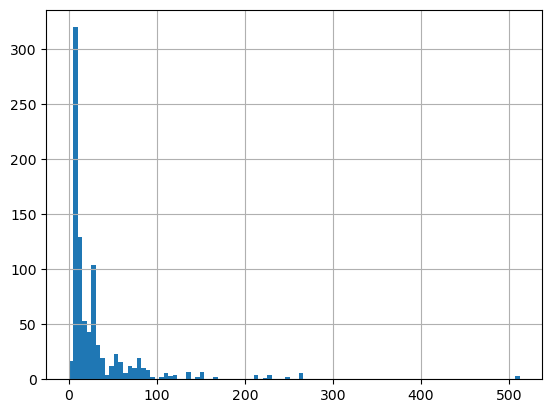

In [133]:
_ = df["Fare"].hist(bins=100)

The most common approach is to apply the logarithm function on the values. Let's visualize the effect of the logarithm function on the feature range *(0, 500)*:

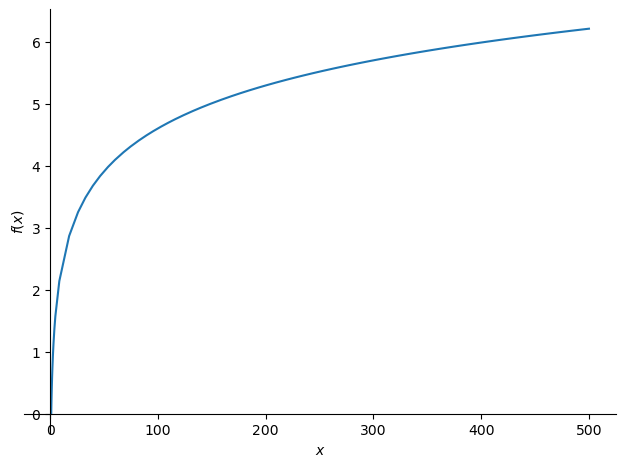

In [134]:
# Visualize the function
x = sympy.symbols('x')
_ = sympy.plot(log(x), (x, 1, 500))
plt.show()

The logarithm function effectively compresses the initial range to a manageable one *(0, 6)*.

Let's apply the technique on our *Fare* feature:

In [135]:
df["LogFare"] = np.log(df["Fare"] + 1)

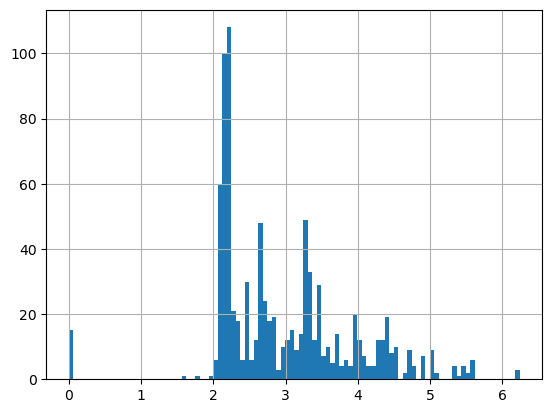

In [136]:
# Visualize again
# A range that is more manageable by most ML algorithms
_ = df["LogFare"].hist(bins=100)

Next is the *pclass* feature. Let's confirm that it only contains three numerical values (we hence can consider it to be a categorical feature):

In [137]:
df["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Let's describe the non-numeric features:

In [138]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


The problem with categorical features is that we can't multiply their values with coefficients or parameters. 

The solution is to first turn them into dummy variables (binary) then drop the original ones:

In [139]:
df = pd.get_dummies(df, columns=["Sex", "Pclass", "Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

Let's check out the columns that have been added:

In [140]:
added_cols = ['Sex_male', 'Sex_female', 
              'Pclass_1', 'Pclass_2', 'Pclass_3', 
              'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


Let's create our independent (predictors) and dependent (targe) variables.

We will represent both as Torch tensors. 

Our dependent variable is *Survived*"

In [141]:
y = tensor(df["Survived"])
y.shape

torch.Size([891])

Our independent variables are all the continuous variables plus the dummy binary variables:

In [142]:
indep_cols = ["Age", "SibSp", "Parch", "LogFare"] + added_cols
len(indep_cols)

12

In [143]:
X = tensor(df[indep_cols].values, dtype=torch.float)
X.shape

torch.Size([891, 12])

## Setting up a linear model

- We have prepared our input to output tensors.
- We can now work on calculating our predictions and loss.
- We will start with constructing a single step towards minimizing the loss.
- Our first model will be a simple linear model.
- We'll need a *W_i* for each column.
- We'll initialize the parameters randomly in the range *(-.5, +.5)*. 
- We will set our manual random seed to ganrantee reproducibility.

In [144]:
X.shape

torch.Size([891, 12])

In [145]:
torch.manual_seed(442)

# Get the number of features to construct *W*
features = X.shape[1]

# Init the parameter matrix uniformely in (-.5,+.5)
W = torch.rand(features) - .5
W.shape

torch.Size([12])

Prediction is done like this:

In [146]:
X.shape, W.shape

(torch.Size([891, 12]), torch.Size([12]))

In [147]:
X*W

tensor([[-10.1838,   0.1386,   0.0000,  ...,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  ...,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  ...,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.1096,   0.1386,   0.4818,  ...,  -0.0000,   0.0000,   0.3625],
        [-12.0354,   0.0000,   0.0000,  ...,  -0.4392,   0.0000,   0.0000],
        [-14.8128,   0.0000,   0.0000,  ...,  -0.0000,   0.2103,   0.0000]])

The sums of each row will be dominated by the first column (*age*), since it's range is bigger on average than all the others.

Let's make all the columns contain numbers from *0* to *1* by dividing each column by its *max()*:

In [148]:
maxes, _ = X.max(dim=0)
X = X / maxes

As we see, that removes the problem of one column dominating all the others:

In [149]:
X*W

tensor([[-0.1273,  0.0173,  0.0000,  ..., -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000,  ..., -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1389,  0.0173,  0.0803,  ..., -0.0000,  0.0000,  0.3625],
        [-0.1504,  0.0000,  0.0000,  ..., -0.4392,  0.0000,  0.0000],
        [-0.1852,  0.0000,  0.0000,  ..., -0.0000,  0.2103,  0.0000]])

We can now create our predictions from the linear model using the *@* operator:

In [150]:
y_hat = X@W
y_hat.shape

torch.Size([891])

Let's take a look at the first few:

In [151]:
y_hat[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,
         0.1613, -0.6285])

To do gradient descent, we need a loss function. Let's implement the mean-absolute-error loss function:

In [152]:
loss = torch.abs(y_hat - y).mean()
loss

tensor(0.5382)

Let's create functions for the above code:

In [153]:
def predict(W, X): return X@W
def get_loss(W, X, y): return torch.abs(predict(W, X) - y).mean()

## Doing a gradient descent step

- We are going to do a single epoch of gradient descent manually.
- The only thing we are going to automate is the calulation of gradients. We will leave that to *pytorch*.
- We'll need to call *requires_grad_()* on our *W*.

In [154]:
W.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,
         0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

Now we can calculate the loss and keep track of the gradients as follows:

In [155]:
loss = get_loss(W, X, y)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

We use *backward()* to ask PyTorch to calculate the gradients w.r.t the parameters:

In [156]:
loss.backward()

Let's check out what they look like:

In [157]:
W.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,
         0.1425, -0.1886, -0.0191,  0.2043])

Notice that each time we call *backward()*, the gradients get added to *.grad*, let's verify this:

In [158]:
loss = get_loss(W, X, y)
loss.backward()
W.grad

tensor([-0.0212,  0.0258, -0.0082, -0.0969,  0.4198, -0.4265, -0.2424, -0.0494,
         0.2851, -0.3771, -0.0382,  0.4085])

After we use the gradients to conduct the step, we need to set them back to *0*:

In [160]:
loss = get_loss(W, X, y)
loss.backward()
with torch.no_grad():
    W -= W.grad * .1
    W.grad.zero_()
    print(get_loss(W, X, y))

tensor(0.4984)


## Training the linear model

- We have to hold out a validation set for calculating our metrics.
- We will use a *RandomSplitter* to get indices that will split our data into *train* and *test*.

In [162]:
train_split, val_split = RandomSplitter(seed=42)(df)

We'll use the indices to split the dataset:

In [165]:
X_train, y_train = X[train_split], y[train_split]
X_val, y_val = X[val_split], y[val_split]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

(torch.Size([713, 12]),
 torch.Size([713]),
 torch.Size([178, 12]),
 torch.Size([178]))

We'll create functions for the 3 tasks:
- Updating *coeffs*.
- 1 full gradient descent step.
- Initializing *W* to random numbers.

In [166]:
def update_weights(W, lr):
    W -= (W.grad * lr)
    W.grad.zero_()

In [168]:
def one_epoch(W, lr):
    loss = get_loss(W, X_train, y_train)
    loss.backward()
    with torch.no_grad(): 
        update_weights(W, lr)
        print(f"{loss:.3f}", end="; ")

In [169]:
def init_W(): return (torch.rand(features) - .5).requires_grad_()

We can use the functions to train the model:

In [170]:
def train(epochs=30, lr=.01):
    torch.manual_seed(442)
    W = init_W()
    for _ in range(epochs): one_epoch(W, lr=lr)
    return W

Let's try it:

In [171]:
W = train(18, .2)

0.536; 0.502; 0.477; 0.454; 0.431; 0.409; 0.388; 0.367; 0.349; 0.336; 0.330; 0.326; 0.329; 0.304; 0.314; 0.296; 0.300; 0.289; 

Let's take a look at the coefficients for each column:

In [173]:
def show_coeffs(): return dict(zip(indep_cols, W.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2694),
 'SibSp': tensor(0.0901),
 'Parch': tensor(0.2359),
 'LogFare': tensor(0.0280),
 'Sex_male': tensor(-0.3990),
 'Sex_female': tensor(0.2345),
 'Pclass_1': tensor(0.7232),
 'Pclass_2': tensor(0.4112),
 'Pclass_3': tensor(0.3601),
 'Embarked_C': tensor(0.0955),
 'Embarked_Q': tensor(0.2395),
 'Embarked_S': tensor(0.2122)}

## Measuring accuracy

Let's start by calculating the predictions:

In [174]:
y_hat = predict(W, X_val)
y_hat.shape

torch.Size([178])

Let's collapse the predictions into *0* or *1*:

In [184]:
(y_val.bool() == (y_hat > .5)).float().mean()

tensor(0.7865)

Let's create a function that takes the weights and returns the overall accuracy:

In [187]:
def acc(W): return (y_val.bool() == (X_val@W > .5)).float().mean()
acc(W)

tensor(0.7865)

## Using sigmoid

Looking at our predictions, there's one obvious problem -- some of our predictions of the probability of survival are `>1`, and some are `<0`:

In [189]:
y_hat[:28]

tensor([ 0.8160,  0.1295, -0.0148,  0.1831,  0.1520,  0.1350,  0.7279,  0.7754,
         0.3222,  0.6740,  0.0753,  0.0389,  0.2216,  0.7631,  0.0678,  0.3997,
         0.3324,  0.8278,  0.1078,  0.7126,  0.1023,  0.3627,  0.9937,  0.8050,
         0.1153,  0.1455,  0.8652,  0.3425])

To fix this, we should pass every prediction through the *sigmoid function*, which has a minimum at zero and maximum at one, and is defined as follows:

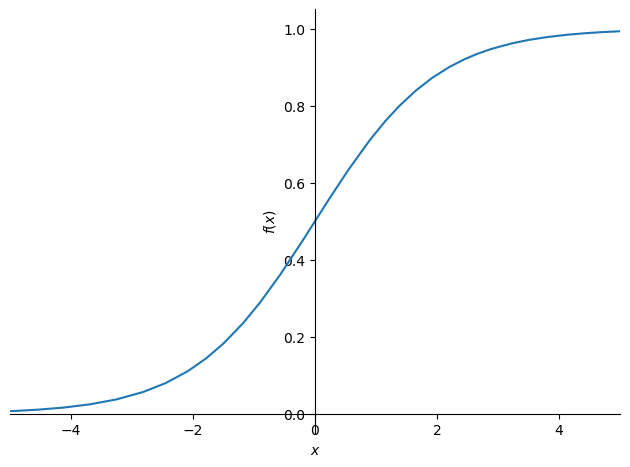

In [191]:
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

PyTorch already defines that function for us, so we can modify `calc_preds` to use it:

In [192]:
def predict(W, X): return torch.sigmoid(X@W)

Let's train a new model now, using this updated function to calculate predictions:

In [194]:
W = train(lr=100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

The loss has improved by a lot. Let's check the accuracy:

In [195]:
acc(W)

tensor(0.8258)

That's improved too! Here's the coefficients of our trained model:

In [196]:
show_coeffs()

{'Age': tensor(-1.5061),
 'SibSp': tensor(-1.1575),
 'Parch': tensor(-0.4267),
 'LogFare': tensor(0.2543),
 'Sex_male': tensor(-10.3320),
 'Sex_female': tensor(8.4185),
 'Pclass_1': tensor(3.8389),
 'Pclass_2': tensor(2.1398),
 'Pclass_3': tensor(-6.2331),
 'Embarked_C': tensor(1.4771),
 'Embarked_Q': tensor(2.1168),
 'Embarked_S': tensor(-4.7958)}

These coefficients seem reasonable -- in general, older people and males were less likely to survive, and first class passengers were more likely to survive.

## Submitting to Kaggle

Now that we've got a trained model, we can prepare a submission to Kaggle. To do that, first we need to read the test set:

In [202]:
tst_df = pd.read_csv(dataset_path / "test.csv")

In this case, it turns out that the test set is missing `Fare` for one passenger. We'll just fill it with `0` to avoid problems:

In [203]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

Now we can just copy the same steps we did to our training set and do the same exact things on our test set to preprocess the data:

In [204]:
tst_df.fillna(modes, inplace=True)
tst_df["LogFare"] = np.log(tst_df["Fare"] + 1)
tst_df = pd.get_dummies(tst_df, columns=["Sex", "Pclass", "Embarked"])
X_test = tensor(tst_df[indep_cols].values, dtype=torch.float)
X_test = X_test / maxes

Let's calculate our predictions of which passengers survived in the test set:

In [208]:
tst_df['Survived'] = (predict(W, X_test) > 0.5).int()

The sample submission on the Kaggle competition site shows that we're expected to upload a CSV with just `PassengerId` and `Survived`, so let's create that and save it:

In [209]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

We can check the first few rows of the file to make sure it looks reasonable:

In [210]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


When you click "save version" in Kaggle, and wait for the notebook to run, you'll see that `sub.csv` appears in the "Data" tab. Clicking on that file will show a *Submit* button, which allows you to submit to the competition.

## Using matrix product

We can make things quite a bit neater...

Take a look at the inner-most calculation we're doing to get the predictions:

In [211]:
(X_val * W).sum(axis=1)

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3512, -13.6469,   3.6248,
          5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,   3.9393,
        -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237,
        -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,  -2.7433, -12.3210,
        -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,
         -3.2275, -12.0289,  13.4560, -21.7230,  -3.1366, -13.2462, -21.7230,
        -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,
         -2.9386,  -5.3103, -22.2384, -22.1097, -21.7466, -13.3780, -13.4909,
        -14.8119, -22.0690, -21.6666, -21.7818,  -5.4440, -21.7407, -12.6551,
        -21.6671,   4.9238, -11.5777, -13.3323, -21.9638, -15.3030,   5.0243,
        -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230,
        -11.9652, -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,
          4.9207,  -7.3198,  -5.3081,   7.1066,  11.4948, -13.31

Multiplying elements together and then adding across rows is identical to doing a matrix-vector product! Python uses the `@` operator to indicate matrix products, and is supported by PyTorch tensors. Therefore, we can replicate the above calculate more simply like so:

In [212]:
X_val @ W

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3512, -13.6469,   3.6248,
          5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,   3.9393,
        -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237,
        -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,  -2.7433, -12.3210,
        -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,
         -3.2275, -12.0289,  13.4560, -21.7230,  -3.1366, -13.2462, -21.7230,
        -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,
         -2.9386,  -5.3103, -22.2384, -22.1097, -21.7466, -13.3780, -13.4909,
        -14.8119, -22.0690, -21.6666, -21.7818,  -5.4440, -21.7407, -12.6551,
        -21.6671,   4.9238, -11.5777, -13.3323, -21.9638, -15.3030,   5.0243,
        -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230,
        -11.9652, -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,
          4.9207,  -7.3198,  -5.3081,   7.1066,  11.4948, -13.31

It also turns out that this is much faster, because matrix products in PyTorch are very highly optimised.

Let's use this to replace how `calc_preds` works:

In [214]:
def predict(W, X): return torch.sigmoid(X@W)

In order to do matrix-matrix products (which we'll need in the next section), we need to turn `coeffs` into a column vector (i.e. a matrix with a single column), which we can do by passing a second argument `1` to `torch.rand()`, indicating that we want our coefficients to have one column:

In [216]:
def init_coeffs(): return (torch.rand(features, 1) * .1).requires_grad_()

We'll also need to turn our dependent variable into a column vector, which we can do by indexing the column dimension with the special value `None`, which tells PyTorch to add a new dimension in this position:

In [219]:
y_train = y_train[:, None]
y_val = y_val[:, None]
y_train.shape, y_val.shape

(torch.Size([713, 1]), torch.Size([178, 1]))

We can now train our model as before and confirm we get identical outputs...:

In [220]:
W = train(lr=100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

...and identical accuracy:

In [222]:
acc(W)

tensor(0.8258)

## A neural network

- We've got all of the components we need to implement a full neural network.
- Steps:
    1. Create coefficients for each one of our layers (*features* -> *n_hidden*).
    2. We'll divide the coefficients by *n_hidden*.
    3. The second layer will have a (*n_hidden* -> *1*) mapping. 
    4. We will add a single learnable constant (bias) to the output of the second layer.

In [249]:
def init_weights(n_hidden=20):
    W1 = (torch.rand(features, n_hidden) - .5) / n_hidden
    W2 = torch.rand(n_hidden, 1) - .3
    bias = torch.rand(1)[0]
    return W1.requires_grad_(), W2.requires_grad_(), bias.requires_grad_()

- Now we have our coefficients, we can create our neural net.
- The key steps are the two matrix products, `indeps@l1` and `res@l2` (where `res` is the output of the first layer). - The first layer output is passed to `F.relu` (that's our non-linearity), and the second is passed to `torch.sigmoid` as before.

In [250]:
def predict(Ws, X):
    W1, W2, bias = Ws
    act = F.relu(X@W1)
    act = act@W2 + bias
    return torch.sigmoid(act)

Finally, now that we have more than one set of coefficients, we need to add a loop to update each one:

In [251]:
def update_weights(Ws, lr):
    for W in Ws:
        W -= (W.grad * lr)
        W.grad.zero_()

Let's create the final *train()* function:

In [252]:
def train(epochs=30, lr=.01):
    torch.manual_seed(442)
    W = init_weights()
    for _ in range(epochs): one_epoch(W, lr=lr)
    return W

That's it -- we're now ready to train our model!

In [253]:
W = train(lr=1.4)

0.544; 0.538; 0.532; 0.526; 0.519; 0.512; 0.504; 0.495; 0.486; 0.476; 0.465; 0.455; 0.444; 0.434; 0.426; 0.418; 0.412; 0.407; 0.403; 0.400; 0.397; 0.395; 0.393; 0.391; 0.390; 0.389; 0.388; 0.387; 0.387; 0.386; 

In [254]:
coeffs = train(lr=20)

0.544; 0.464; 0.388; 0.382; 0.381; 0.380; 0.380; 0.380; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 0.379; 

It's looking good -- our loss is lower than before. Let's see if that translates to a better result on the validation set:

In [257]:
def acc(W): 
    y_hat = predict(W, X_val)
    return (y_val.bool() == (y_hat > .5)).float().mean()

In [258]:
acc(W)

tensor(0.5955)

In this case our neural net isn't showing better results than the linear model. That's not surprising; this dataset is very small and very simple, and isn't the kind of thing we'd expect to see neural networks excel at. Furthermore, our validation set is too small to reliably see much accuracy difference. But the key thing is that we now know exactly what a real neural net looks like!

## Deep learning

The neural net in the previous section only uses one hidden layer, so it doesn't count as "deep" learning. But we can use the exact same technique to make our neural net deep, by adding more matrix multiplications.

First, we'll need to create additional coefficients for each layer:

In [267]:
def init_weights():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [features] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

You'll notice here that there's a lot of messy constants to get the random numbers in just the right ranges. When you train the model in a moment, you'll see that the tiniest changes to these initialisations can cause our model to fail to train at all! This is a key reason that deep learning failed to make much progress in the early days -- it's very finicky to get a good starting point for our coefficients. Nowadays, we have ways to deal with that, which we'll learn about in other notebooks.

Our deep learning `calc_preds` looks much the same as before, but now we loop through each layer, instead of listing them separately:

In [268]:
import torch.nn.functional as F

def predict(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

We also need a minor update to `update_coeffs` since we've got `layers` and `consts` separated now:

In [269]:
def update_weights(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

Let's train our model...

In [270]:
W = train(lr=4)

0.531; 0.484; 0.470; 0.457; 0.447; 0.437; 0.430; 0.424; 0.419; 0.414; 0.411; 0.408; 0.405; 0.403; 0.401; 0.400; 0.398; 0.397; 0.396; 0.395; 0.394; 0.393; 0.392; 0.392; 0.391; 0.391; 0.390; 0.390; 0.389; 0.389; 

...and check its accuracy:

In [272]:
acc(W)

tensor(0.5955)

## Final thoughts

It's actually pretty cool that we've managed to create a real deep learning model from scratch and trained it to get over 80% accuracy on this task, all in the course of a single notebook!

The "real" deep learning models that are used in research and industry look very similar to this, and in fact if you look inside the source code of any deep learning model you'll recognise the basic steps are the same.

The biggest differences in practical models to what we have above are:

- How initialisation and normalisation is done to ensure the model trains correctly every time
- Regularization (to avoid over-fitting)
- Modifying the neural net itself to take advantage of knowledge of the problem domain
- Doing gradient descent steps on smaller batches, rather than the whole dataset.

I'll be adding notebooks about all these later, and will add links here once they're ready.

If you found this notebook useful, please remember to click the little up-arrow at the top to upvote it, since I like to know when people have found my work useful, and it helps others find it too. (BTW, be sure you're looking at my [original notebook here](https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch) when you do that, and are not on your own copy of it, otherwise your upvote won't get counted!) And if you have any questions or comments, please pop them below -- I read every comment I receive!

---